In [26]:
# Libraries
import numpy as np
import numba
import networkx as nx
import matplotlib.pyplot as plt

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets

In [27]:
a = np.expand_dims(np.random.uniform(size=10),0)
b = np.expand_dims(np.random.uniform(size=10),0)

In [28]:
a

array([[0.93042319, 0.56971963, 0.9886059 , 0.15666286, 0.28744402,
        0.28293555, 0.73572522, 0.03784943, 0.02170695, 0.19118979]])

In [29]:
b

array([[0.82383153, 0.79222521, 0.96074212, 0.82857603, 0.29260439,
        0.7871202 , 0.04728438, 0.48914778, 0.49131024, 0.32561018]])

In [30]:
a = np.vstack((a,b))
a

array([[0.93042319, 0.56971963, 0.9886059 , 0.15666286, 0.28744402,
        0.28293555, 0.73572522, 0.03784943, 0.02170695, 0.19118979],
       [0.82383153, 0.79222521, 0.96074212, 0.82857603, 0.29260439,
        0.7871202 , 0.04728438, 0.48914778, 0.49131024, 0.32561018]])

Init disordered Network Topology and Electrostatic Properties:
- Number of nanopartciles $N_{NP}$ and number of junctions per $N_{J}$
- Electrode Positions as list of cartesian coordinates `[[x_1, y_1], [x_2, y_2], [x_3, y_3], ...]` \
Network is placed inside box of size 1 with electrodes attached to closest nanoparticle

In [31]:
# Network Style
network_topology = "random"

# Network Parameter
topology_parameter  = {
    "Np"    : 5,
    "Nj"    : 4,
    "e_pos" : [[-1,-1],[1,1]]
}

# Save Folder
folder  = "test_runs/"

# Topology Class
np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)

Display Network Topology

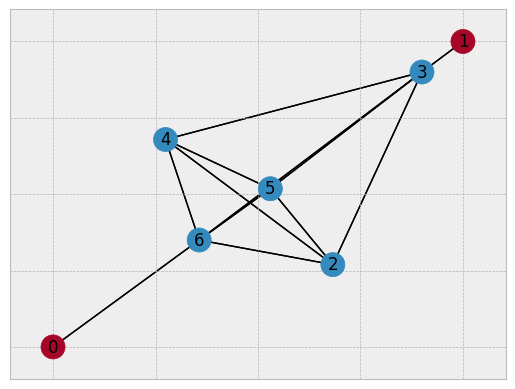

In [32]:
# Node Positions
fixed_pos                               = {i : val for i, val in enumerate(topology_parameter["e_pos"])}
pos                                     = nx.spring_layout(G=np_network_sim.G, pos=fixed_pos, fixed=[i for i in range(np_network_sim.N_electrodes)])
pos_vals                                = np.array(list(dict(sorted(pos.items())).values()))
pos_vals_e                              = pos_vals[np_network_sim.N_electrodes:]
pos_vals_e                              = 1.6*(pos_vals_e - np.min(pos_vals_e,axis=0))/(np.max(pos_vals_e,axis=0) - np.min(pos_vals_e,axis=0)) - 0.8
pos_vals[np_network_sim.N_electrodes:]  = pos_vals_e

for i in range(np_network_sim.N_particles):
    pos[i] = pos_vals[i,:]

# Node Colors
colors                                  = np.repeat('#348ABD', np_network_sim.N_particles+np_network_sim.N_electrodes)
colors[-np_network_sim.N_electrodes:]   = '#A60628'

# Display Graph
with plt.style.context(["bmh"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    nx.draw_networkx(G=np_network_sim.G, pos=pos, ax=ax, node_color=colors, arrows=False)
    plt.show()

Input Voltages

Number of Steps: 20000


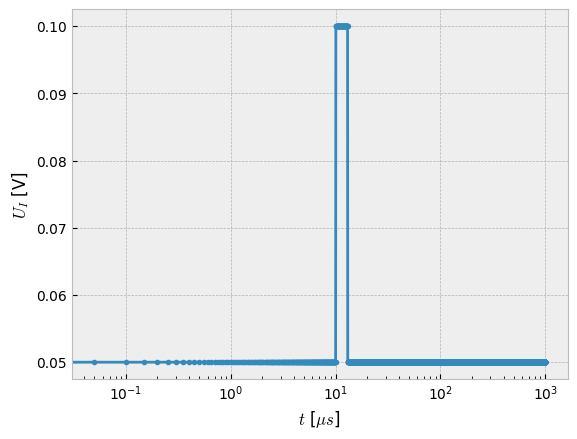

In [33]:
# Define Time Scale
step_size   = 5e-8
max_time    = 10e-4
time_steps  = np.arange(0,max_time,step_size)
N_steps     = len(time_steps)
print(f"Number of Steps: {N_steps}")

# Define Peak
t_min_peak  = 10e-6
t_max_peak  = 13e-6
peak_bounds = (time_steps >= t_min_peak) & (time_steps <= t_max_peak)

# Input Voltages
input_volt              = np.repeat(0.05,N_steps)
input_volt[peak_bounds] = 0.1

# Voltage Array
voltages        = np.zeros((N_steps, np_network_sim.N_electrodes+1))
voltages        = np.zeros((N_steps, np_network_sim.N_electrodes+1))
voltages[:,0]   = input_volt

# Plot
with plt.style.context("bmh"):
    
    plt.plot(time_steps*10**6, input_volt, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [V]")
    plt.xscale('log')
    plt.show()

In [34]:
store_per_it_min, store_per_it_max = 12e-6, 14e-6 #0,0
stored_indices = np.where((time_steps >= store_per_it_min) & (time_steps < store_per_it_max))[0]
np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)
np_network_sim.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=1, save_th=.1, store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max)

# Zeitskala ausgeben

In [36]:
pot_per_it = np_network_sim.return_pot_per_it()

pot_per_it[stored_indices[0]]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1       , 0.        , 0.04319598, ..., 0.04319598, 0.06050063,
        0.05307724],
       [0.1       , 0.        , 0.04198893, ..., 0.04198893, 0.04069134,
        0.04996907],
       ...,
       [0.1       , 0.        , 0.05486054, ..., 0.05486054, 0.07033813,
        0.09024874],
       [0.1       , 0.        , 0.05167832, ..., 0.05167832, 0.06913107,
        0.08918979],
       [0.1       , 0.        , 0.05061937, ..., 0.05061937, 0.0660229 ,
        0.07219247]])

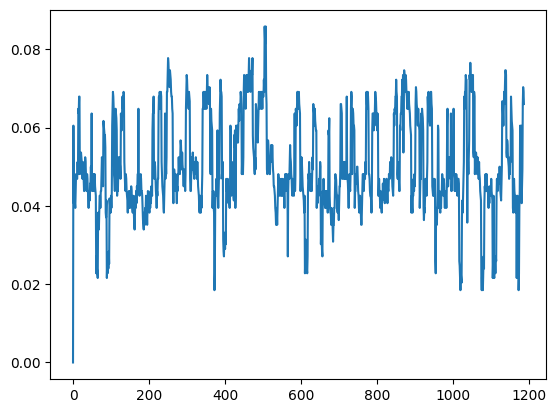

In [49]:
plt.plot(pot_per_it[stored_indices[0]][:,5])
plt.show()

In [27]:
return_jumps_per_it = np_network_sim.return_jumps_per_it()
return_jumps_per_it[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
start_val   = 100

# Return Output Current
output_vals = np_network_sim.return_output_values()
output_I    = output_vals[:,2]/1000
output_I    = output_I[start_val:]

# Return Microstate
microstate  = np_network_sim.return_microstates()
microstate  = microstate[start_val:]

# Return Landscape
landscape   = np_network_sim.return_potential_landscape()
landscape   = landscape[start_val:]

# Return Network Currents
jump_paths, network_I   = np_network_sim.return_network_currents()
network_I               = network_I[start_val:]

In [13]:
print(f"Average Jumps per Step: {np.round(np.mean(output_vals[1:,1] - output_vals[:-1,1]),2)}")

Average Jumps per Step: 394.61


### Output electric Current

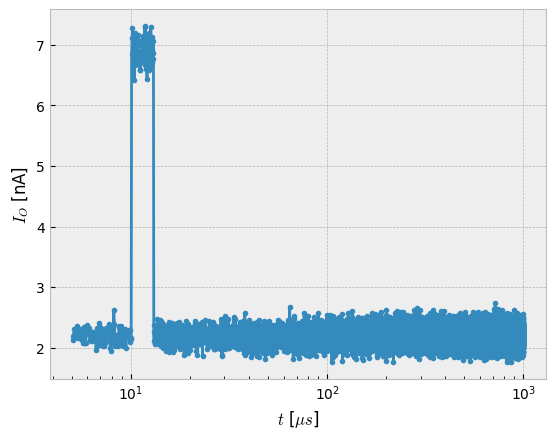

In [14]:
with plt.style.context("bmh"):
    
    plt.plot(time_steps[start_val+1:]*10**6, output_I, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$I_O$ [nA]")
    plt.xscale('log')
    plt.show()

#### Micro State

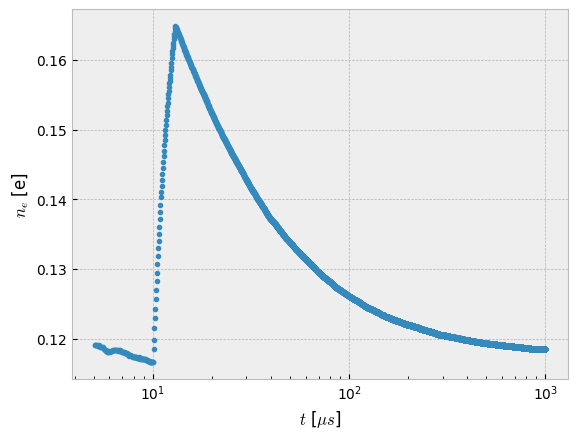

In [15]:
with plt.style.context("bmh"):
    
    plt.plot(time_steps[start_val+1:]*10**6, microstate[:,0], '.')
    # plt.plot(time_steps[1:]*10**6, microstate[:,-1], '.')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$n_e$ [e]")
    plt.xscale('log')
    plt.show()

#### NP Potential

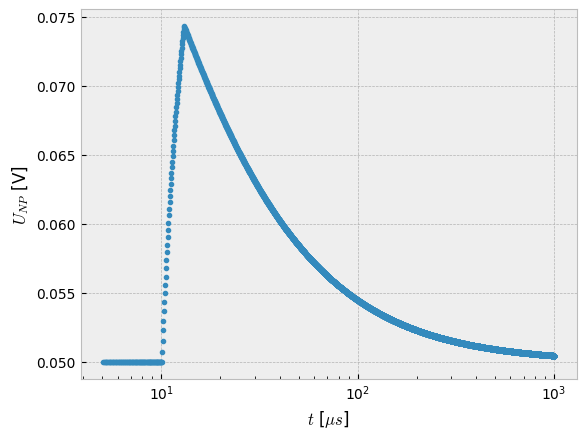

In [16]:
with plt.style.context("bmh"):
    
    plt.plot(time_steps[start_val+1:]*10**6, landscape[:,0], '.')
    # plt.plot(time_steps[1:]*10**6, microstate[:,-1], '.')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_{NP}$ [V]")
    plt.xscale('log')
    plt.show()

#### NP Current

In [17]:
jump_paths

[(0, 6),
 (1, 3),
 (2, 3),
 (2, 6),
 (2, 5),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 6),
 (3, 5),
 (4, 6),
 (4, 3),
 (4, 5),
 (4, 2),
 (5, 6),
 (5, 2),
 (5, 4),
 (5, 3),
 (6, 0),
 (6, 4),
 (6, 2),
 (6, 5),
 (6, 3)]

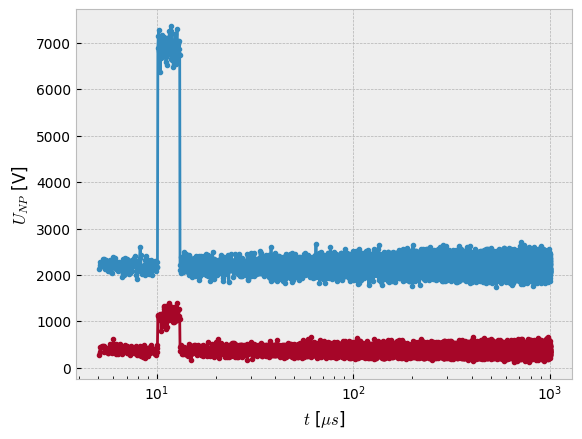

In [18]:
with plt.style.context("bmh"):
    
    plt.plot(time_steps[start_val+1:]*10**6, network_I[:,0], '.-')
    plt.plot(time_steps[start_val+1:]*10**6, network_I[:,18], '.-')
    # plt.plot(time_steps[1:]*10**6, microstate[:,-1], '.')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_{NP}$ [V]")
    plt.xscale('log')
    plt.show()

In [19]:
# with plt.style.context("bmh"):
    
#     plt.plot(input_volt[start_val+1:], output_I, '.')
#     plt.xlabel("$U_I$ [V]")
#     plt.ylabel("$I_O$ [nA]")
#     # plt.ylim(-8,8)
#     plt.show()